In [20]:
#Import packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm

In [13]:
#Read CSV
elections = pd.read_csv("../data/processed/elections.csv")

In [14]:
#Select relevant columns from the 'elections' DataFrame for training
train = elections[['Total_Receipt', 'Receipts_Sum', 'Receipts_Prop', 'Won Primary']]

#Initialize a LabelEncoder to convert categorical labels into numeric format
label_encoder = LabelEncoder()

#Fit the LabelEncoder on the 'Won Primary' column and transform it to numeric values
train['Won Primary'] = label_encoder.fit_transform(train['Won Primary'])

#Define feature matrix (X) and target vector (y)
X = train[['Total_Receipt', 'Receipts_Sum', 'Receipts_Prop']]
y = train['Won Primary']

#Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/var/folders/9p/g4b_94bd7fggx8kn5fnnsdc00000gn/T/ipykernel_68343/330355431.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Won Primary'] = label_encoder.fit_transform(train['Won Primary'])


In [15]:
# Add a constant (intercept) to the feature matrix
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit logistic GLM using statsmodels
logit_model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
logit_results = logit_model.fit()

# Print the summary of the model
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            Won Primary   No. Observations:                  511
Model:                            GLM   Df Residuals:                      507
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -170.24
Date:                Thu, 22 Aug 2024   Deviance:                       340.48
Time:                        17:24:11   Pearson chi2:                     613.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.4237
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -2.8485      0.347     -8.219

In [16]:
#Calculating the AIC
aic = -2 * logit_results.llf + 2 * (logit_results.params.shape[0])
print("AIC for Logistic GLM:", aic)

AIC for Logistic GLM: 348.47773176704175


In [17]:
#Get model predictions
predictions_glm = logit_results.predict(X_test)
y_pred_glm = [0 if x < 0.5 else 1 for x in predictions_glm]
y_prob_glm = predictions_glm

# Calculate residuals
residuals_glm = y_pred_glm - y_test

# Calculate squared residuals
squared_residuals_glm = residuals_glm ** 2

# Calculate mean of squared residuals
mean_squared_residuals_glm = np.mean(squared_residuals_glm)

# Calculate RMSE
rmse_glm = np.sqrt(mean_squared_residuals_glm)

print("RMSE:", rmse_glm)

RMSE: 0.42389562394532926


Accuracy: 0.82
Precision: 0.73
Recall: 0.78
ROC AUC: 0.90


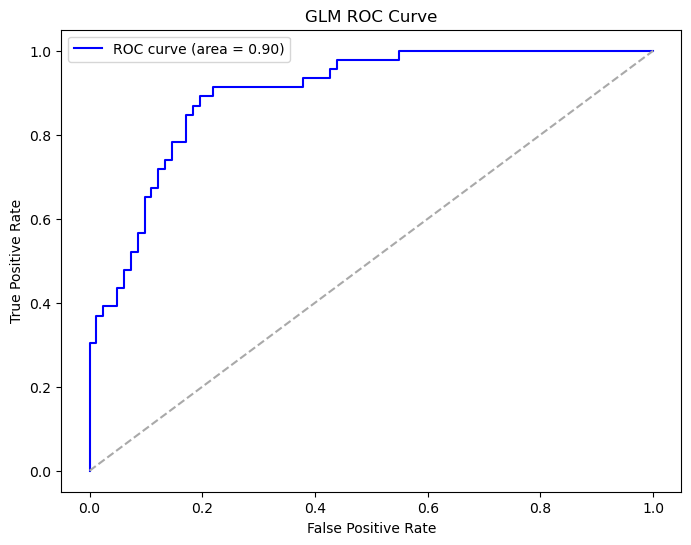

In [19]:
#Calcuate model evaluation metrics
glm_accuracy = accuracy_score(y_test, y_pred_glm)
glm_precision = precision_score(y_test, y_pred_glm)
glm_recall = recall_score(y_test, y_pred_glm)
glm_roc_auc = roc_auc_score(y_test, y_prob_glm)

#Print model evaluation metrics
print(f'Accuracy: {glm_accuracy:.2f}')
print(f'Precision: {glm_precision:.2f}')
print(f'Recall: {glm_recall:.2f}')
print(f'ROC AUC: {glm_roc_auc:.2f}')

#Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_glm)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {glm_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='darkgray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GLM ROC Curve')
plt.legend()
plt.show()

In [21]:
def calculate_specificity_sensitivity(y_true, y_pred):
    """Function that given true and predicted values returns specificity and sensitivity"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    return specificity, sensitivity

# Calculate specificity and sensitivity
specificity_glm, sensitivity_glm = calculate_specificity_sensitivity(y_test, y_pred_glm)

print("GLM Specificity:", specificity_glm)
print("GLM Sensitivity:", sensitivity_glm)

GLM Specificity: 0.8414634146341463
GLM Sensitivity: 0.782608695652174
